In [2]:
# Import Core library
import sys
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, nltk
import emoji
from pprint import pprint
from cleantext import clean

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [3]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to C:\Users\Ivory-
[nltk_data]     UALR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Import Dataset
df = pd.read_excel('Community306_raw.xlsx')

In [6]:
df.columns

Index(['Unnamed: 0', 'id', 'source_id', 'created_at', 'geo_source',
       'truncated', 'text', 'text_sentiment', 'text_toxicity', 'lang', 'user',
       'Community', 'retweet_count', 'favorite_count', 'quote_count',
       'reply_count', 'retweet_id_str', 'is_quote_status',
       'quoted_status_id_str', 'in_reply_to_status_id_str',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'entities',
       'possibly_sensitive', 'coordinates', 'place'],
      dtype='object')

In [7]:
df['create_year'] = pd.to_datetime(df.created_at, format='%d/%m/%Y', errors='coerce')
df['year'] = pd.to_datetime(df.created_at).dt.strftime('%Y')
df['month'] = pd.to_datetime(df.created_at).dt.strftime('%m')

In [8]:
start_date = "15/12/2020"
end_date = "31/01/2021"
after_start_date = df['create_year'] > start_date
before_end_date = df['create_year'] < end_date
between_two_dates = after_start_date & before_end_date

stream_one = df.loc[between_two_dates]

In [9]:
# Convert to list
data = stream_one['text'].values.tolist()

# Make characters lowercase
data = [word.lower() for word in data]

In [10]:
def get_url_patern():
    return re.compile(
        r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'
        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')

def get_hashtags_pattern():
    return re.compile(r'#\w*')

def get_single_letter_words_pattern():
    return re.compile(r'(?<![\w\-])\w(?![\w\-])')

def get_blank_spaces_pattern():
    return re.compile(r'\s{2,}|\t')

def get_twitter_reserved_words_pattern():
    return re.compile(r'(RT|rt|FAV|fav|VIA|via)')

def get_mentions_pattern():
    return re.compile(r'@\w*')

def process_text(word):
  word=re.sub(pattern=get_url_patern(), repl='', string=word)
  word=re.sub(pattern=get_mentions_pattern(), repl='', string=word)
  word=re.sub(pattern=get_hashtags_pattern(), repl='', string=word)
  word=re.sub(pattern=get_twitter_reserved_words_pattern(), repl='', string=word)
  word=re.sub(pattern=get_single_letter_words_pattern(), repl='', string=word)
  word=re.sub(pattern=get_blank_spaces_pattern(), repl=' ', string=word)
  word=re.sub('\s+', ' ', word)
  word=re.sub("\'", "", word)
  word=re.sub(r'http\S+', '', word)  # remove http links
  word=re.sub(r'bit.ly/\S+', '', word)  # rempve bitly links
  word=word.strip('[link]')  # remove [links]
  word=re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', word)  # remove retweet
  word=re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', word)  # remove tweeted at
  word=clean(word, no_emoji=True)
  word =re.sub(r'\d+', '', word)
  word = word.strip()
  return word

<>:28: DeprecationWarning: invalid escape sequence \s
<>:33: DeprecationWarning: invalid escape sequence \s
<>:28: DeprecationWarning: invalid escape sequence \s
<>:33: DeprecationWarning: invalid escape sequence \s
C:\Users\IVORY-~1\AppData\Local\Temp/ipykernel_18968/2930402903.py:28: DeprecationWarning: invalid escape sequence \s
  word=re.sub('\s+', ' ', word)
C:\Users\IVORY-~1\AppData\Local\Temp/ipykernel_18968/2930402903.py:33: DeprecationWarning: invalid escape sequence \s
  word=re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', word)  # remove retweet


In [11]:
data = [process_text(word) for word in data]

C:\Users\Ivory-UALR\AppData\Local\Programs\Python\Python39\lib\site-packages\cleantext\clean.py:58: DeprecationWarning: invalid escape sequence '\/'
  text = text.encode("latin", "backslashreplace").decode("unicode-escape")
C:\Users\Ivory-UALR\AppData\Local\Programs\Python\Python39\lib\site-packages\cleantext\clean.py:58: DeprecationWarning: invalid escape sequence '\/'
  text = text.encode("latin", "backslashreplace").decode("unicode-escape")
C:\Users\Ivory-UALR\AppData\Local\Programs\Python\Python39\lib\site-packages\cleantext\clean.py:58: DeprecationWarning: invalid escape sequence '\/'
  text = text.encode("latin", "backslashreplace").decode("unicode-escape")
C:\Users\Ivory-UALR\AppData\Local\Programs\Python\Python39\lib\site-packages\cleantext\clean.py:58: DeprecationWarning: invalid escape sequence '\/'
  text = text.encode("latin", "backslashreplace").decode("unicode-escape")
C:\Users\Ivory-UALR\AppData\Local\Programs\Python\Python39\lib\site-packages\cleantext\clean.py:58: Depr

In [12]:
def getUniqueItems(iterable):
    result = []
    for item in iterable:
        if item not in result:
            result.append(item)
    return result

In [13]:
unique_items = getUniqueItems(data)

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(unique_items))

print(data_words[:10])

[[], ['is', 'my'], ['is', 'my'], [], ['dem', 'can', 'stop', 'me', 'from', 'screaming'], ['did', 'fail', 'to', 'mention'], ['stay', 'away', 'from', 'dc', 'wed', 'jan', 'let', 'trump', 'brownshis', 'do', 'their', 'violent', 'protest', 'thing', 'alone'], [], ['all', 'you', 'losers', 'that', 'suppoed', 'the', 'fraud', 'election', 'are', 'weak', 'communist', 'di', 'bags'], ['deceify', 'the', 'fraudulent', 'vote', 'deceify', 'the', 'fraudulent', 'vote']]


In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

[]


In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 40000000

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[[]]


In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:10])

[[], [], [], [], [(0, 1), (1, 1)], [(2, 1), (3, 1)], [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)], [], [(12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)], [(20, 2), (21, 2), (22, 2)]]


In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\Ivory-UALR\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.443669 -0.034483       1        1  19.335353
5     -0.013755  0.436795       2        1  15.079819
2     -0.044619 -0.071079       3        1  11.130735
8     -0.048624 -0.056237       4        1  10.323474
0     -0.057324 -0.052952       5        1   8.262561
1     -0.055618 -0.045924       6        1   7.943782
7     -0.057817 -0.042174       7        1   7.786864
4     -0.053136 -0.049038       8        1   7.719605
3     -0.053206 -0.045580       9        1   6.955893
6     -0.059569 -0.039328      10        1   5.461914, topic_info=           Term         Freq        Total Category  logprob  loglift
15     election  6398.000000  6398.000000  Default  30.0000  30.0000
22         vote  3751.000000  3751.000000  Default  29.0000  29.0000
202       stand  2287.000000  2287.000000  Default  28.0000  28.0000
83          get  2550.000000  2550.000000  Default  27.0000  27.0000
54       people  2313.000000  2313.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
2103    promise    84.698814    85.654317  Topic10  -5.0172   2.8962
2037      troop    83.374086    84.329857  Topic10  -5.0330   2.8960
2426    attempt    83.093570    84.049043  Topic10  -5.0364   2.8959
959        sell    81.552608    82.508060  Topic10  -5.0551   2.8957
1102  interview    78.881619    79.837235  Topic10  -5.0884   2.8953

[330 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
386      10  0.995783     action
793       3  0.994556        add
1649     10  0.989743     afraid
163       2  0.996377      agree
2977      5  0.997206        aka
...     ...       ...        ...
99        6  0.998015       work
259       8  0.997902      world
951       6  0.998323      wrong
447       6  0.999029       year
1651     10  0.987029  yesterday

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 3, 9, 1, 2, 8, 5, 4, 7])

In [21]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.1930,"election, fraud, right, steal, know, voter, sa...",
1,1,9.0,0.1930,"election, fraud, right, steal, know, voter, sa...",
2,2,9.0,0.1930,"election, fraud, right, steal, know, voter, sa...",
3,3,9.0,0.1930,"election, fraud, right, steal, know, voter, sa...",
4,4,5.0,0.1943,"want, see, take, evidence, stop, call, let, ha...",
5,5,9.0,0.1831,"election, fraud, right, steal, know, voter, sa...",
6,6,7.0,0.2192,"trump, patriot, country, thing, great, even, s...",
7,7,9.0,0.1930,"election, fraud, right, steal, know, voter, sa...",
8,8,9.0,0.2078,"election, fraud, right, steal, know, voter, sa...",
9,9,3.0,0.1993,"vote, time, fraudulent, lose, electoral, judge...",


In [25]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2415,"get, go, watch, hope, day, corrupt, freedom, a...",: fight for trump!
1,1.0,0.2185,"people, president, history, year, work, hear, ...",et' not forget what dumb ass trump is!!
2,2.0,0.3907,"need, state, american, help, well, pay, cheat,...",: replay of the th president of the united sta...
3,3.0,0.3007,"vote, time, fraudulent, lose, electoral, judge...",
4,4.0,0.2056,"senator, count, think, traitor, result, do, wo...",: the crowd at the ellipse had many
5,5.0,0.3316,"want, see, take, evidence, stop, call, let, ha...",tried to warn people before the trap ask aj wh...
6,6.0,0.2135,"stand, make, way, look, much, ignorant, action...",
7,7.0,0.4583,"trump, patriot, country, thing, great, even, s...","guys, they did this to shut us down. it not ti..."
8,8.0,0.3112,"thank, fight, suppo, give, show, law, ballot, ...",jail all the domestic terrorist
9,9.0,0.3964,"election, fraud, right, steal, know, voter, sa...",: crece crece la multitud de patriotas en apoy...


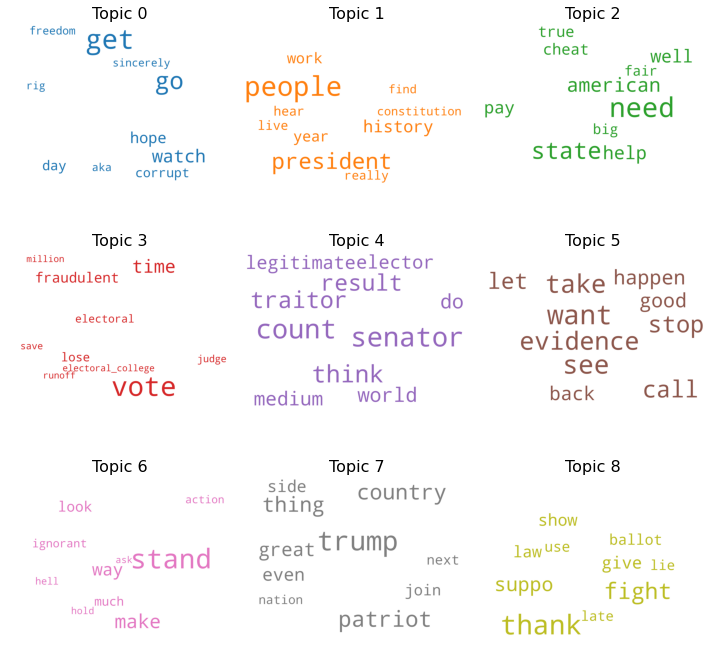

In [26]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()